In [1]:
from analogainas.search_spaces.config_space import ConfigSpace
from analogainas.search_spaces.autoencoder.autoencoder_config_space import AutoEncoderConfigSpace
from analogainas.search_spaces.autoencoder.autoencoder_architecture import AutoEncoder
from analogainas.evaluators.evaluation_metrics import negative_mse_metric
from analogainas.search_spaces.dataloaders.autoencoder_structured_dataset import AutoEncoderStructuredDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from analogainas.analog_helpers.analog_helpers import create_rpu_config, create_analog_optimizer
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import WeightClipType
from aihwkit.simulator.configs.utils import BoundManagementType
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.nn.conversion import convert_to_analog_mapped
from aihwkit.nn import AnalogSequential
from aihwkit.optim import AnalogSGD

In [3]:
import aihwkit.inference.noise.pcm as pcm

import aihwkit

print(aihwkit.__version__)

0.9.0


In [4]:
from aihwkit.simulator.configs import InferenceRPUConfig

In [5]:
noise_model = pcm.PCMLikeNoiseModel()
rpu_config = create_rpu_config()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
CS = AutoEncoderConfigSpace()

In [8]:
CS.get_hyperparameters()

['embedding_dim', 'encoder_convblock1_depth', 'encoder_convblock1_kernel_size', 'encoder_convblock1_filters', 'encoder_convblock1_stride', 'encoder_convblock2_depth', 'encoder_convblock2_kernel_size', 'encoder_convblock2_filters', 'encoder_convblock2_stride', 'encoder_convblock3_depth', 'encoder_convblock3_kernel_size', 'encoder_convblock3_filters', 'encoder_convblock3_stride', 'decoder_convblock1_depth', 'decoder_convblock1_kernel_size', 'decoder_convblock1_filters', 'decoder_convblock1_stride', 'decoder_convblock2_depth', 'decoder_convblock2_kernel_size', 'decoder_convblock2_filters', 'decoder_convblock2_stride', 'decoder_convblock3_depth', 'decoder_convblock3_kernel_size', 'decoder_convblock3_filters', 'decoder_convblock3_stride']


In [9]:
CS.compute_cs_size()

134898444140544

In [10]:
# Can use this in the AutoEncoder to see random behaviour
configs = CS.sample_arch_uniformly(5) 

optimal_config={'embedding_dim': 256, 'encoder_convblock1_depth': 1, 'encoder_convblock1_kernel_size': 5, 'encoder_convblock1_filters': 64, 'encoder_convblock1_stride': 1, 'encoder_convblock2_depth': 1, 'encoder_convblock2_kernel_size': 3, 'encoder_convblock2_filters': 32, 'encoder_convblock2_stride': 1, 'encoder_convblock3_depth': 1, 'encoder_convblock3_kernel_size': 7, 'encoder_convblock3_filters': 16, 'encoder_convblock3_stride': 2} 

In [11]:
sample_autoencoder = AutoEncoder(optimal_config, input_channels=1, input_size=(28,28))

Need FC Out: False
Decoded Shape: torch.Size([1, 28, 28])
Input Size: (28, 28)


In [12]:
configs[0]

{'embedding_dim': 1024,
 'encoder_convblock1_depth': 3,
 'encoder_convblock1_kernel_size': 7,
 'encoder_convblock1_filters': 8,
 'encoder_convblock1_stride': 2,
 'encoder_convblock2_depth': 1,
 'encoder_convblock2_kernel_size': 3,
 'encoder_convblock2_filters': 16,
 'encoder_convblock2_stride': 1,
 'encoder_convblock3_depth': 3,
 'encoder_convblock3_kernel_size': 7,
 'encoder_convblock3_filters': 16,
 'encoder_convblock3_stride': 1,
 'decoder_convblock1_depth': 4,
 'decoder_convblock1_kernel_size': 5,
 'decoder_convblock1_filters': 32,
 'decoder_convblock1_stride': 2,
 'decoder_convblock2_depth': 4,
 'decoder_convblock2_kernel_size': 3,
 'decoder_convblock2_filters': 512,
 'decoder_convblock2_stride': 2,
 'decoder_convblock3_depth': 1,
 'decoder_convblock3_kernel_size': 3,
 'decoder_convblock3_filters': 16,
 'decoder_convblock3_stride': 1}

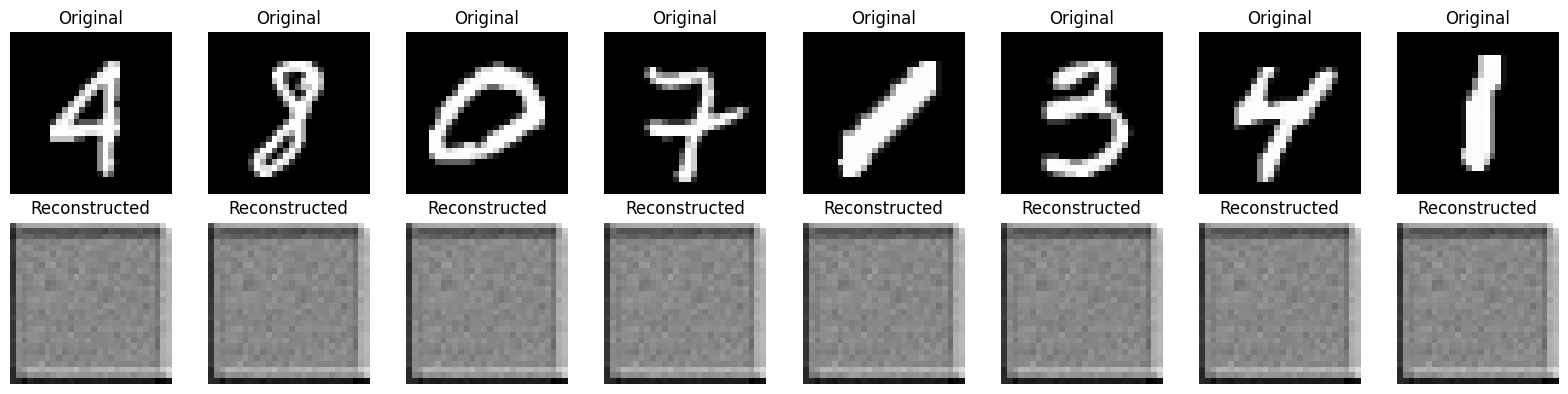

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = AutoEncoderStructuredDataset(torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True))
dataloader = DataLoader(mnist_dataset, batch_size=8, shuffle=True)

test_mnist_dataset = AutoEncoderStructuredDataset(torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True))
test_dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

images, labels = next(iter(dataloader))

with torch.no_grad():
    reconstructions = sample_autoencoder(images)

def imshow(img_tensor):
    img = img_tensor.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
    plt.axis('off')

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))

for i in range(8):
    axes[0, i].imshow(images[i][0].cpu().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")
    
    recon_img = reconstructions[i][0].cpu().numpy()
    axes[1, i].imshow(recon_img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

In [14]:
def show_performance(_autoencoder, _dataloader):
    _autoencoder.eval()
    _autoencoder = _autoencoder.to(torch.device('cpu'))
    with torch.no_grad():
        test_images, _ = next(iter(_dataloader))
        test_images = test_images.to(torch.device('cpu'))
        test_recon = _autoencoder(test_images)

    negative_mse = negative_mse_metric(_dataloader, _autoencoder)
    print("Negative MSE: ", sum(negative_mse)/len(negative_mse))
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(test_images[i][0].cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
  
        recon_img = test_recon[i][0].cpu().numpy()
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sample_autoencoder.parameters(), lr=1e-3)

sample_autoencoder = sample_autoencoder.to(device)
epochs = 3
sample_autoencoder.train()

AutoEncoder(
  (encoder): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): ReLU(inplace=True)
      )
    )
  )
  (fc_mu): Linear(in_features=3136, out_features=256, bias=True)
  (fc_dec): Linear(in_features=256, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): DeconvBlock(
      (block): Sequential(
        (0): ConvTranspose2d(16, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DeconvBlock(
      (block): Sequential(
        (0): ConvTranspose2d(16,

In [16]:
print(sample_autoencoder.need_fc_out)

False


In [17]:
for epoch in range(epochs):
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        recon = sample_autoencoder(images)
        loss = criterion(recon, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}], Loss: {loss.item()}")

Epoch [1/3], Step [0], Loss: 0.09075005352497101
Epoch [1/3], Step [50], Loss: 0.0652596578001976
Epoch [1/3], Step [100], Loss: 0.03364739194512367
Epoch [1/3], Step [150], Loss: 0.030423851683735847
Epoch [1/3], Step [200], Loss: 0.021313954144716263
Epoch [1/3], Step [250], Loss: 0.015737982466816902
Epoch [1/3], Step [300], Loss: 0.015357216820120811
Epoch [1/3], Step [350], Loss: 0.015173817053437233
Epoch [1/3], Step [400], Loss: 0.00987423025071621
Epoch [1/3], Step [450], Loss: 0.012409692630171776
Epoch [1/3], Step [500], Loss: 0.011592996306717396
Epoch [1/3], Step [550], Loss: 0.011721593327820301
Epoch [1/3], Step [600], Loss: 0.008701864629983902
Epoch [1/3], Step [650], Loss: 0.007764971815049648
Epoch [1/3], Step [700], Loss: 0.008655715733766556
Epoch [1/3], Step [750], Loss: 0.007815146818757057
Epoch [1/3], Step [800], Loss: 0.008181435987353325
Epoch [1/3], Step [850], Loss: 0.007450096309185028
Epoch [1/3], Step [900], Loss: 0.006321186665445566
Epoch [1/3], Step [9

Negative MSE:  -0.0008309022939231779


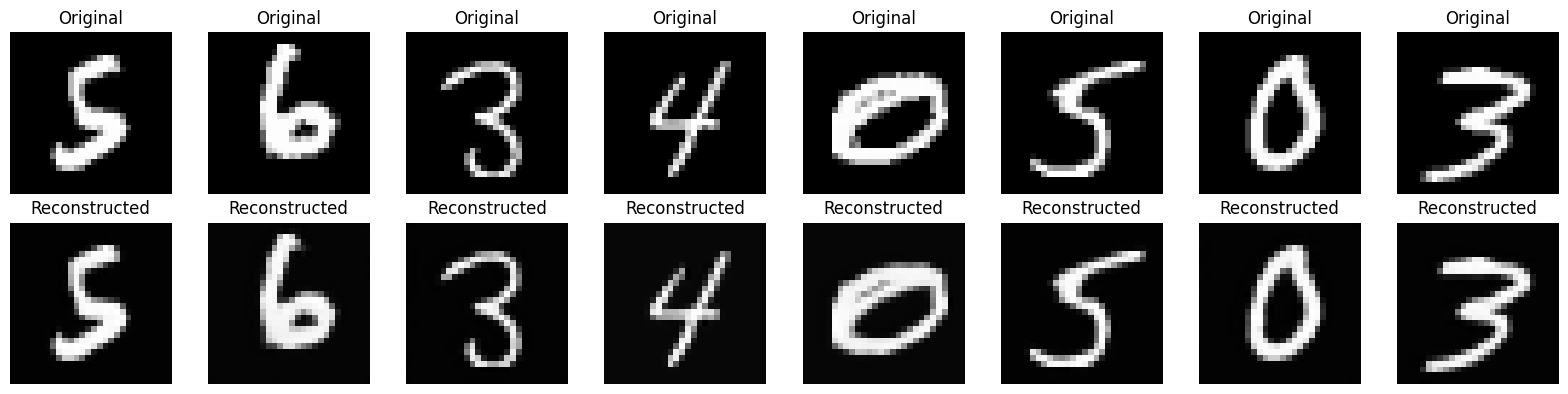

In [18]:
show_performance(sample_autoencoder, test_dataloader)

In [19]:
device = torch.device('cpu')
analog_sample_autoencoder = sample_autoencoder.to(torch.device('cpu'))
analog_sample_autoencoder = convert_to_analog_mapped(sample_autoencoder, rpu_config)

analog_sample_autoencoder.drift_analog_weights(24 * 60 * 60 * 1)

Negative MSE:  -0.03018673961716039


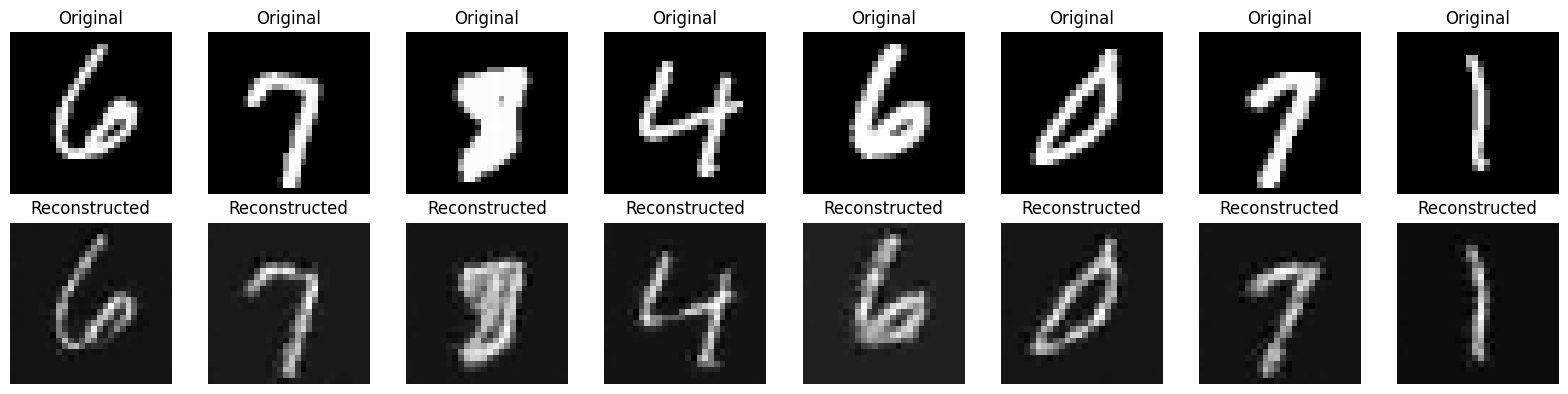

In [20]:
show_performance(analog_sample_autoencoder, test_dataloader)

In [21]:
analog_sample_autoencoder.drift_analog_weights(24 * 60 * 60 * 30)

Negative MSE:  -0.056683049138103216


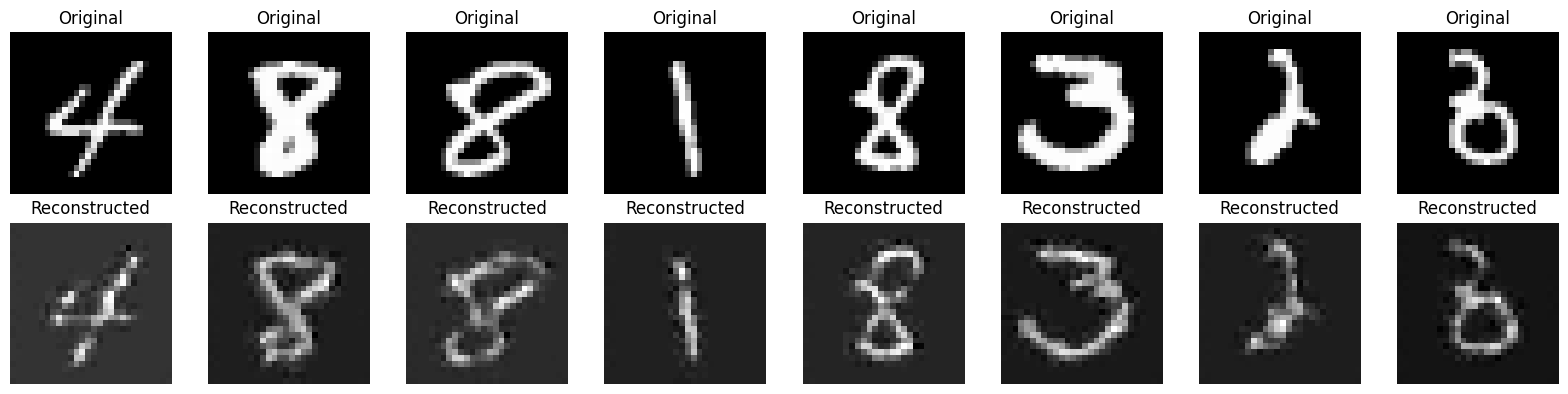

In [22]:
show_performance(analog_sample_autoencoder, test_dataloader)